In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Pretrained models in PyTorch expect images at least 224x224, scaled to (0,1), normalized with these values:
# https://pytorch.org/vision/stable/models.html

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [6]:
# https://www.kaggle.com/c/dogs-vs-cats
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

train_dir = 'datasets/cats_or_dogs/train'
test_dir = 'datasets/cats_or_dogs/test'

batch_size = 8
num_workers = 4

In [7]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)

In [8]:
train_data

Dataset ImageFolder
    Number of datapoints: 2002
    Root location: datasets/cats_or_dogs/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

In [10]:
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

In [11]:
test_data 

Dataset ImageFolder
    Number of datapoints: 1012
    Root location: datasets/cats_or_dogs/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=num_workers)

In [13]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [14]:
total_batch_sizes = { 'train': len(train_loader), 'test': len(test_loader) }

In [15]:
total_batch_sizes

{'train': 251, 'test': 127}

In [16]:
class_names = train_data.classes

print(class_names)

['cats', 'dogs']


In [17]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))
    
    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)

In [18]:
inputs, classes = next(iter(dataloaders['train']))

In [19]:
out = torchvision.utils.make_grid(inputs)

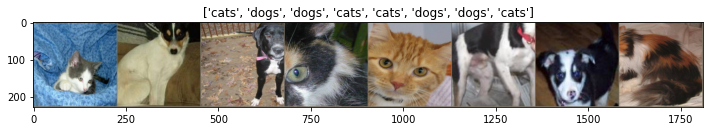

In [20]:
imshow(out, title=[class_names[x] for x in classes])

## Load pretrained VGG model

In [21]:
from torchvision import models

In [22]:
model = models.vgg16(pretrained=True)

In [23]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
'''
(classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  
  )
'''
# (6): Linear(in_features=4096, out_features=1000, bias=True)

'\n(classifier): Sequential(\n    (0): Linear(in_features=25088, out_features=4096, bias=True)\n    (1): ReLU(inplace=True)\n    (2): Dropout(p=0.5, inplace=False)\n    (3): Linear(in_features=4096, out_features=4096, bias=True)\n    (4): ReLU(inplace=True)\n    (5): Dropout(p=0.5, inplace=False)\n    \n    (6): Linear(in_features=4096, out_features=1000, bias=True)\n  \n  )\n'

In [25]:
# number of in_features

num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [26]:
model.classifier[6].out_features

1000

In [27]:
#  Freeze all layers of the model so we use the same model weights as the pretrained model
# Parameters will not be updated because no gradients are calculated

for param in model.parameters():
    param.requires_grad = False

In [28]:
# The most important line is as follows:
# The last layer's weights get updated

model.classifier[6] = nn.Linear(num_ftrs, 2)

In [29]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
'''
(classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
   
   (6): Linear(in_features=4096, out_features=2, bias=True)
  )
'''
# (6): Linear(in_features=4096, out_features=2, bias=True)

'\n(classifier): Sequential(\n    (0): Linear(in_features=25088, out_features=4096, bias=True)\n    (1): ReLU(inplace=True)\n    (2): Dropout(p=0.5, inplace=False)\n    (3): Linear(in_features=4096, out_features=4096, bias=True)\n    (4): ReLU(inplace=True)\n    (5): Dropout(p=0.5, inplace=False)\n   \n   (6): Linear(in_features=4096, out_features=2, bias=True)\n  )\n'

In [31]:
# define a loss function
criterion        = nn.CrossEntropyLoss()

# define optimizer
optimizer_ft     = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# define learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):

    model = model.to(device)
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            
            if phase == 'train':
                
                scheduler.step()
                model.train()  
                
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / total_batch_sizes[phase]
            epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    print('Training complete')

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [33]:
model = train_model(model, criterion, optimizer_ft,
                    exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


C:\Users\platon\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.2830 Acc: 0.9203
test Loss: 0.3331 Acc: 0.9843
Epoch 1/4
----------
train Loss: 1.0690 Acc: 0.9397
test Loss: 0.3718 Acc: 0.9803
Epoch 2/4
----------
train Loss: 1.1429 Acc: 0.9417
test Loss: 0.4090 Acc: 0.9793
Epoch 3/4
----------
train Loss: 1.0734 Acc: 0.9457
test Loss: 0.3608 Acc: 0.9833
Epoch 4/4
----------
train Loss: 0.9971 Acc: 0.9472
test Loss: 0.3429 Acc: 0.9872
Training complete
Best val Acc: 0.987205


In [34]:
model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the test images: 99.11067193675889%


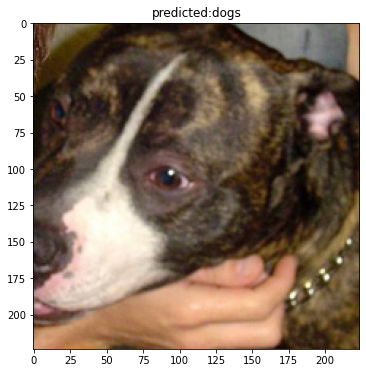

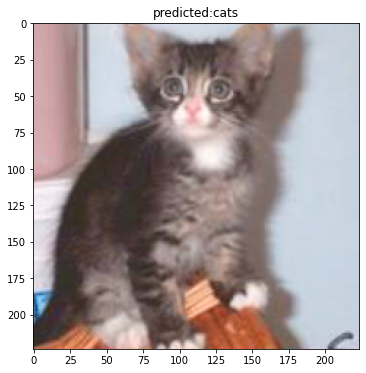

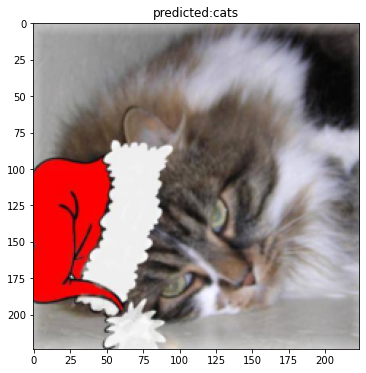

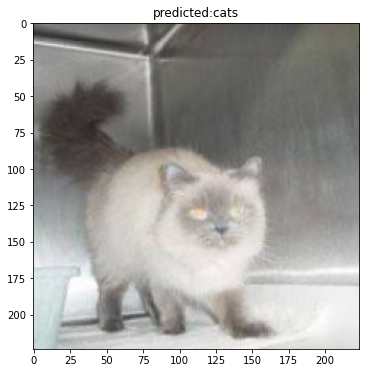

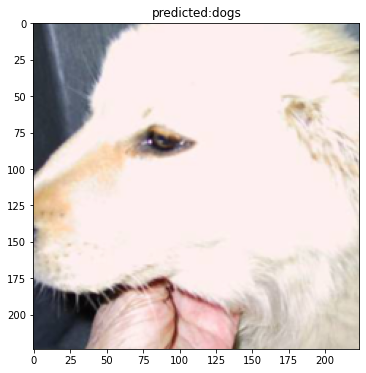

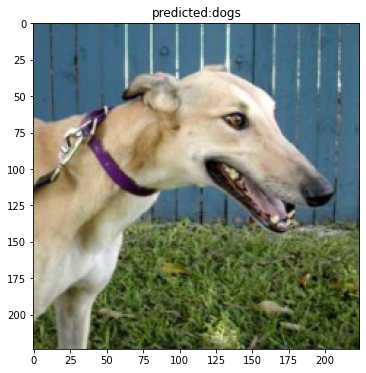

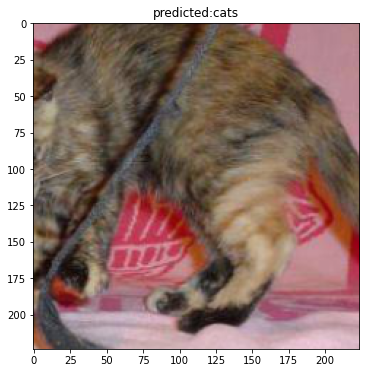

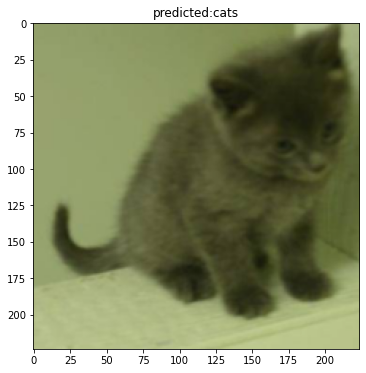

In [35]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])